## Anomaly Detection- windowed method 

In [1]:
import numpy as np
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.layers import Lambda, Input, Dense, Dropout

Importing the dataset

In [2]:
data = pd.read_csv("data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv",
                   parse_dates=True, index_col="timestamp")

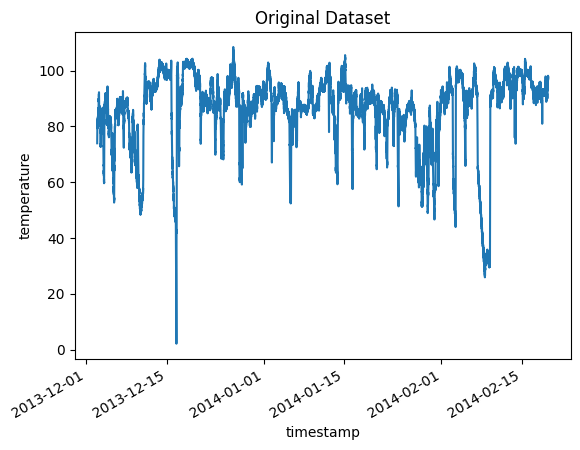

In [3]:
fig, ax = plt.subplots()
data.plot(legend=False, ax=ax)
plt.ylabel("temperature")
plt.title("Original Dataset")
plt.show()

Splitting training and testing

In [4]:
# Splitting to train and test
test_ratio =0.3
start = int(len(data) * 0.25 )  # or 0 
tr_data = data.iloc[start: int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]
tst_data2 = data.iloc[0:start]

In [5]:
tr_data

,value
timestamp,
2013-12-22 14:00:00,87.168898
2013-12-22 14:05:00,87.933798
2013-12-22 14:10:00,85.804768
2013-12-22 14:15:00,85.955663
2013-12-22 14:20:00,86.815269
...,...
2014-01-26 23:40:00,88.470506
2014-01-26 23:45:00,88.395883
2014-01-26 23:50:00,88.608302


Normailzing the training set 

In [6]:
# Normalize and save the mean and std we get, for normalizing test data.
training_mean = tr_data.mean()
training_std = tr_data.std()
train_scaled = (tr_data - training_mean) / training_std
print("Number of training samples:", len(train_scaled))

Number of training samples: 10213


Function to create the windowed data

In [7]:
# Generated training sequences for use in the model.
def create_sequences(values, time_steps):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [8]:
step_size = 288

train = create_sequences(train_scaled.values, step_size)
print("Training input shape: ", train.shape)

Training input shape:  (9926, 288, 1)


VAE model

In [9]:
# # Reparameterization trick
# def sampling(args):
#     z_mean, z_log_var = args
#     epsilon = keras.backend.random_normal(shape=(keras.backend.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0)
#     return z_mean + keras.backend.exp(0.5 * z_log_var) * epsilon

In [10]:
# class VAELossLayer(tf.keras.layers.Layer):
#     def __init__(self, **kwargs):
#         super(VAELossLayer, self).__init__(**kwargs)

#     def call(self, inputs):
#         x, x_decoded_mean, z_mean, z_log_var = inputs
#         # Reshape inputs to have the same shape
#         x = tf.reshape(x, tf.shape(x_decoded_mean))
#         # compute the average MSE error, then scale it up, i.e. simply sum on all axes
#         reconstruction_loss = tf.reduce_sum(tf.square(x - x_decoded_mean))
#         # compute the KL loss
#         kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
#         # return the average loss over all 
#         total_loss = tf.reduce_mean(reconstruction_loss + 0.05*kl_loss)    
#         self.add_loss(total_loss)
#         return x  # Dummy output


In [11]:
from utils.sample import sample
from model.VAELossLayer import VAELossLayer

In [12]:
# Define VAE loss function
def vae_loss(x, x_decoded_mean, z_mean, z_log_var):
    # Reshape inputs to have the same shape
    x = tf.reshape(x, tf.shape(x_decoded_mean))
    
    # Compute reconstruction loss
    reconstruction_loss = tf.reduce_sum(tf.square(x - x_decoded_mean))
    
    # Compute KL divergence
    kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    
    # Combine reconstruction loss and KL divergence
    total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
    
    return total_loss

# Encoder
latent_dim = 8  # Dimensionality of the latent space
encoder_inputs = Input(shape=(train.shape[1], train.shape[2]))
x = layers.Conv1D(
    filters=32,
    kernel_size=7,
    padding="same",
    strides=2,
    activation="relu",
)(encoder_inputs)
x = layers.Dropout(rate=0.2)(x)
x = layers.Conv1D(
    filters=16,
    kernel_size=7,
    padding="same",
    strides=2,
    activation="relu",
)(x)
x = layers.Flatten()(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)

# Use Lambda layer to sample from the latent distribution
z = layers.Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Instantiate encoder model
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = Input(shape=(latent_dim,))
x = Dense(train.shape[1]*16, activation='relu')(latent_inputs)
x = layers.Reshape((int(train.shape[1]/4), 64))(x)  # Adjusted reshape operation
x = layers.Conv1DTranspose(
    filters=32,
    kernel_size=7,
    padding="same",
    strides=2,
    activation="relu",
)(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.Conv1DTranspose(
    filters=16,
    kernel_size=7,
    padding="same",
    strides=2,
    activation="relu",
)(x)
decoder_outputs = layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")(x)


# Instantiate decoder model
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# Instantiate VAE model
outputs = decoder(encoder(encoder_inputs)[2])
vae = keras.Model(encoder_inputs, outputs, name="vae")

# Calculate VAE loss
vae_loss = vae_loss(encoder_inputs, outputs, z_mean, z_log_var)

# Compile VAE model
vae.add_loss(vae_loss)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 288, 1)]             0         []                            
                                                                                                  
 encoder (Functional)        [(None, 8),                  22304     ['input_31[0][0]']            
                              (None, 8),                                                          
                              (None, 8)]                                                          
                                                                                                  
 decoder (Functional)        (None, 288, 1)               59553     ['encoder[0][2]']             
                                                                                                

In [ ]:
history = vae.fit(
    train,
    train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])

Epoch 1/50
70/70 [==============================] - 4s 40ms/step - loss: 18781.8145 - val_loss: 9032.5068
Epoch 2/50
70/70 [==============================] - 3s 38ms/step - loss: 4548.9990 - val_loss: 3906.4592
Epoch 3/50
70/70 [==============================] - 2s 34ms/step - loss: 3058.7144 - val_loss: 2769.4167
Epoch 4/50
70/70 [==============================] - 2s 35ms/step - loss: 2519.9407 - val_loss: 2247.9661
Epoch 5/50
70/70 [==============================] - 2s 35ms/step - loss: 2215.4609 - val_loss: 2388.8967
Epoch 6/50
70/70 [==============================] - 3s 36ms/step - loss: 2025.9698 - val_loss: 2169.8982
Epoch 7/50
70/70 [==============================] - 2s 35ms/step - loss: 1903.4183 - val_loss: 2392.8733
Epoch 8/50
70/70 [==============================] - 2s 35ms/step - loss: 1817.2515 - val_loss: 2472.3669
Epoch 9/50
70/70 [==============================] - 2s 36ms/step - loss: 1789.1428 - val_loss: 2404.7275
Epoch 10/50
70/70 [==============================] - 2

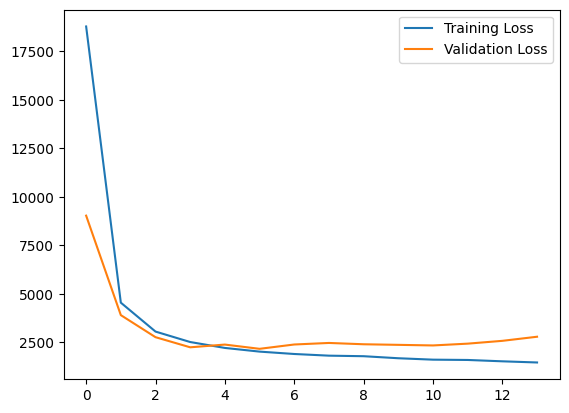

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

311/311 [==============================] - 2s 5ms/step


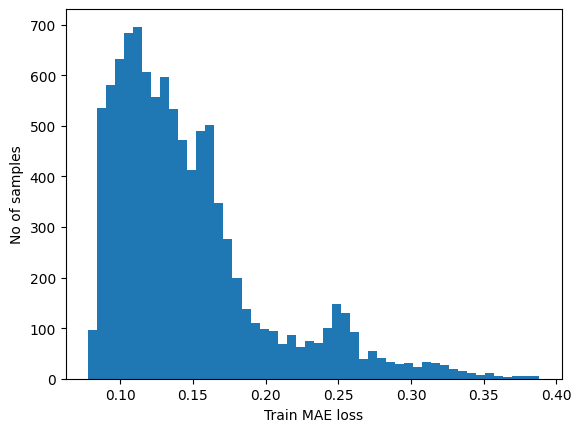

Reconstruction error threshold:  0.3880688644860585


In [ ]:
# Get train MAE loss.
train_pred = vae.predict(train)
train_mae_loss = np.mean(np.abs(train_pred - train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

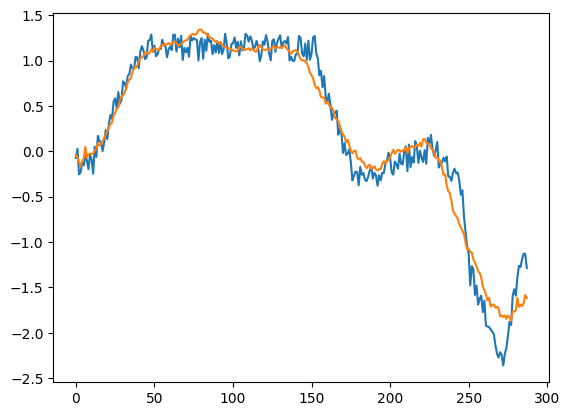

In [ ]:
# Checking how the first sequence is learnt
plt.plot(train[0])
plt.plot(train_pred[0])
plt.show()

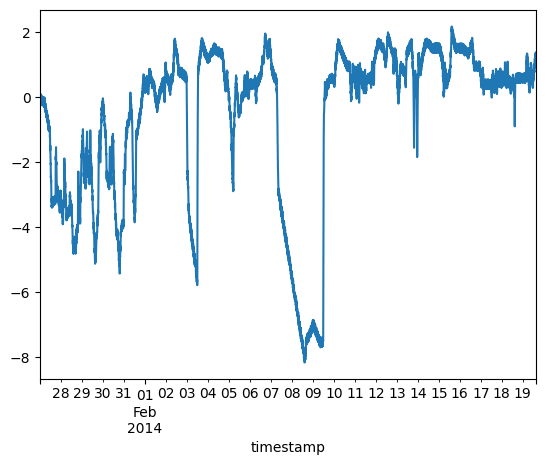

Test input shape:  (6522, 288, 1)
204/204 [==============================] - 1s 4ms/step


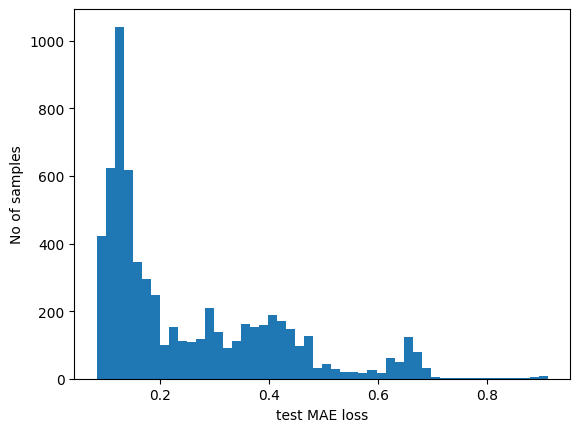

Number of anomaly samples:  1413
Indices of anomaly samples:  (array([ 122,  123,  124, ..., 3878, 3879, 3880], dtype=int64),)


In [ ]:

test_scaled = (tst_data - training_mean) / training_std
fig, ax = plt.subplots()
test_scaled.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
test = create_sequences(test_scaled.values, step_size)
print("Test input shape: ", test.shape)

# Get test MAE loss.
test_pred = vae.predict(test)
test_mae_loss = np.mean(np.abs(test_pred - test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(step_size - 1, len(test_scaled) - step_size + 1):
    if np.all(anomalies[data_idx - step_size + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [ ]:
data['label'] = 1
instances= [["2013-12-10 06:25:00","2013-12-12 05:35:00"],
            ["2013-12-15 17:50:00","2013-12-17 17:00:00"],
            ["2014-01-27 14:20:00","2014-01-29 13:30:00"],
            ["2014-02-07 14:55:00","2014-02-09 14:05:00"]]


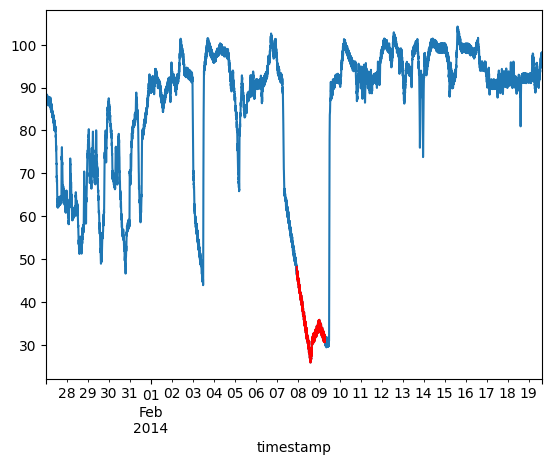

In [ ]:
df_subset = tst_data.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
tst_data.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()